*Load Required Libraries*

In [17]:
# Libraries for data processing
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
from pprint import pprint
import tqdm
import datetime

# NLP set-up 
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmaObj = WordNetLemmatizer()

# Libraries for Word Cloud
from wordcloud import WordCloud
from tqdm import tqdm
from collections import Counter

# Libraries for data processing and extraction
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline

# Libraries for Topic Modelling 
import gensim
from gensim.models import LdaModel, CoherenceModel, LsiModel, HdpModel
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tanay\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\tanay\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df = pd.read_csv('/Users/tanay/Downloads/finalprocessed_data.csv')

In [3]:
df

,Name,Comment,Date,Model,sentiment_score,Source,cleaned_review,sentiment_label
0,Gumpclipper,"Good morning all,I am looking at buying my fir...",2021-10-10,Porsche Macan,5,Pistonheads,good morning looking buying advice essential ...,positive
1,Voodoo Blue,I’m not going to offer an opinion on spec as t...,2021-10-10,Porsche Macan,4,Pistonheads,going offer opinion spec pretty subjective sug...,positive
2,Gumpclipper,Fantastic info. Thank you! Will take a look at...,2021-10-10,Porsche Macan,5,Pistonheads,fantastic info look forum cheer,positive
3,TheBMWDriver,Right now 1% is best you can get on the macan....,2021-10-21,Porsche Macan,4,Pistonheads,right percent best speci find k option make ...,positive
4,neilf,My tip would be to get your name on the deposi...,2021-10-22,Porsche Macan,1,Pistonheads,tip deposit list opc asap way queue decision d...,negative
...,...,...,...,...,...,...,...,...
48940,Binkyjean,The width of the Levante and Grecale are almos...,2022-03-25,Maserati Grecale,2,Forums,width levante inch mirror,negative
48941,Mii,"1,948 mm (76.7 in) is listed on Wiki, should b...",2022-04-02,Maserati Grecale,3,Forums,mm listed wiki width mirror folded http en...,neutral
48942,Harvey Wiggins,"Finally, I found a spec that listed body width...",2022-04-02,Maserati Grecale,3,Forums,finally found spec listed body width mirror wi...,neutral
48943,Mii,"Need to see the gear button control in person,...",2022-04-02,Maserati Grecale,3,Forums,gear button control person non gear lever pref...,neutral


***Analysis of Maserati Grecale***

In [4]:
# Filter rows with Model "Maserati Grecale"
grecale_data = df[df['Model'] == 'Maserati Grecale']

grecale_data

,Name,Comment,Date,Model,sentiment_score,Source,cleaned_review,sentiment_label
47707,Oliie,Looks too much like a Puma,2023-05-10,Maserati Grecale,2,Pistonheads,look like,negative
47708,Rough101,"It does front on in photographs, but in realit...",2023-05-10,Maserati Grecale,2,Pistonheads,photograph reality look like oliie,negative
47709,benjidog,Another generic blob.,2023-05-10,Maserati Grecale,1,Pistonheads,generic blob,negative
47710,TheMilkyBarKid,"Nice enough, but very expensive next to its ri...",2023-05-10,Maserati Grecale,3,Pistonheads,expensive rival thought looking lower touchscr...,neutral
47711,moggy1000,With the rear end of a Fiat Tipo..Not an ugly ...,2023-05-10,Maserati Grecale,3,Pistonheads,rear end fiat tipo ugly plain different price ...,neutral
...,...,...,...,...,...,...,...,...
48940,Binkyjean,The width of the Levante and Grecale are almos...,2022-03-25,Maserati Grecale,2,Forums,width levante inch mirror,negative
48941,Mii,"1,948 mm (76.7 in) is listed on Wiki, should b...",2022-04-02,Maserati Grecale,3,Forums,mm listed wiki width mirror folded http en...,neutral
48942,Harvey Wiggins,"Finally, I found a spec that listed body width...",2022-04-02,Maserati Grecale,3,Forums,finally found spec listed body width mirror wi...,neutral
48943,Mii,"Need to see the gear button control in person,...",2022-04-02,Maserati Grecale,3,Forums,gear button control person non gear lever pref...,neutral


*Pre & Post Launch*

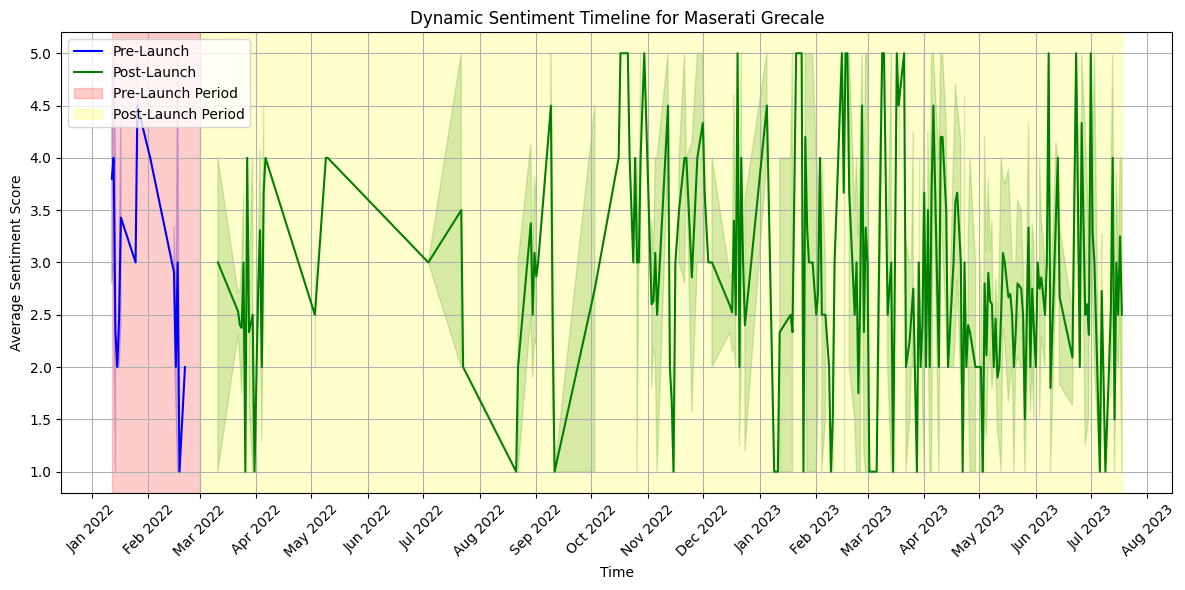

In [5]:
# Convert 'Date' to datetime
grecale_data['Date'] = pd.to_datetime(grecale_data['Date'])

# Define the launch date
launch_date = pd.to_datetime('2022-03-01')

# Separate data into pre-launch and post-launch
pre_launch_data = grecale_data[grecale_data['Date'] < launch_date]
post_launch_data = grecale_data[grecale_data['Date'] >= launch_date]

# Create subplots
fig, ax = plt.subplots(figsize=(12, 6))

# Plot pre-launch sentiment
sns.lineplot(data=pre_launch_data, x='Date', y='sentiment_score', label='Pre-Launch', ax=ax, color='blue')

# Plot post-launch sentiment
sns.lineplot(data=post_launch_data, x='Date', y='sentiment_score', label='Post-Launch', ax=ax, color='green')

# Shade the pre-launch and post-launch areas
ax.axvspan(grecale_data['Date'].min(), launch_date, alpha=0.2, color='red', label='Pre-Launch Period')
ax.axvspan(launch_date, grecale_data['Date'].max(), alpha=0.2, color='yellow', label='Post-Launch Period')

# Beautify the plot
ax.set_title('Dynamic Sentiment Timeline for Maserati Grecale')
ax.set_xlabel('Time')
ax.set_ylabel('Average Sentiment Score')
ax.grid(True)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.legend(loc='upper left')

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

*LDA Model*

In [6]:
# Create Dictionary
dicton = corpora.Dictionary(grecale_data['cleaned_review'].str.split())

# Create Corpus
texts = grecale_data['cleaned_review'].str.split()

# Term Document Frequency
corpus = [dicton.doc2bow(text) for text in texts]

print(corpus[:1][0][:30])

[(0, 1), (1, 1)]


In [7]:
# Build a LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=dicton,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [8]:
# Print the keywords in topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.013*"engine" + 0.013*"suspension" + 0.011*"trofeo" + 0.008*"good" + '
  '0.008*"sport" + 0.006*"mode" + 0.006*"driving" + 0.006*"alfa" + 0.006*"f" + '
  '0.006*"nettuno"'),
 (1,
  '0.015*"charging" + 0.015*"phone" + 0.013*"dealer" + 0.011*"charger" + '
  '0.008*"wife" + 0.008*"position" + 0.007*"week" + 0.007*"driving" + '
  '0.007*"work" + 0.007*"moved"'),
 (2,
  '0.033*"like" + 0.030*"look" + 0.008*"stelvio" + 0.008*"interior" + '
  '0.006*"calliemaserati" + 0.006*"assistance" + 0.006*"message" + '
  '0.006*"direct" + 0.005*"send" + 0.005*"alfa"'),
 (3,
  '0.013*"dealer" + 0.010*"like" + 0.007*"r" + 0.007*"looking" + 0.006*"good" '
  '+ 0.006*"price" + 0.005*"going" + 0.005*"arrive" + 0.005*"hope" + '
  '0.004*"stelvio"'),
 (4,
  '0.011*"look" + 0.009*"driving" + 0.007*"like" + 0.006*"position" + '
  '0.006*"premium" + 0.006*"engine" + 0.006*"day" + 0.006*"work" + '
  '0.006*"start" + 0.006*"year"'),
 (5,
  '0.009*"percent" + 0.008*"issue" + 0.008*"work" + 0.007*"vehicle" +

In [9]:
# Calculate the overall Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dicton, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.42431483143126536


In [10]:
# Supporting Model 
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dicton, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [11]:
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 12
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dicton, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results)
    model_results
    pbar.close()

100%|██████████| 600/600 [1:52:02<00:00, 11.20s/it]


In [12]:
grecale_results= pd.DataFrame(model_results)
grecale_results

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.409092
1,75% Corpus,2,0.01,0.31,0.443635
2,75% Corpus,2,0.01,0.61,0.404636
3,75% Corpus,2,0.01,0.91,0.402902
4,75% Corpus,2,0.01,symmetric,0.412486
...,...,...,...,...,...
595,100% Corpus,11,asymmetric,0.01,0.424733
596,100% Corpus,11,asymmetric,0.31,0.412228
597,100% Corpus,11,asymmetric,0.61,0.416951
598,100% Corpus,11,asymmetric,0.91,0.461350


In [13]:
grecale_results.to_csv('/Users/tanay/Downloads/grecale_cohenrencef.csv', index=False, encoding="utf-8-sig")

In [14]:
# Number of Topics 4 has the highest coherence score, therefore we continue with that
num_topics = 4

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dicton,
                                           num_topics=num_topics, 
                                           random_state=42,
                                           chunksize=100,
                                           passes=15,
                                           alpha=0.02,
                                           eta=0.9)

In [15]:
# Print the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.013*"issue" + 0.007*"work" + 0.005*"key" + 0.004*"problem" + '
  '0.004*"software" + 0.004*"dealer" + 0.004*"day" + 0.004*"macan" + '
  '0.004*"like" + 0.004*"phone"'),
 (1,
  '0.005*"stelvio" + 0.005*"engine" + 0.004*"issue" + 0.004*"like" + '
  '0.003*"display" + 0.003*"mode" + 0.003*"seat" + 0.003*"day" + '
  '0.003*"setting" + 0.003*"alfa"'),
 (2,
  '0.016*"look" + 0.015*"like" + 0.007*"door" + 0.005*"looking" + 0.005*"good" '
  '+ 0.004*"better" + 0.004*"macan" + 0.003*"sound" + 0.003*"dealer" + '
  '0.003*"trofeo"'),
 (3,
  '0.012*"dealer" + 0.007*"delivery" + 0.006*"order" + 0.006*"month" + '
  '0.005*"post" + 0.005*"week" + 0.005*"start" + 0.005*"info" + 0.004*"update" '
  '+ 0.004*"waiting"')]


In [16]:
# Visualize the topics
pyLDAvis.enable_notebook()
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, dicton)

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.014158 -0.064402       1        1  29.310381
2     -0.027989  0.052874       2        1  28.498609
3      0.079449  0.008549       3        1  24.501357
1     -0.037302  0.002980       4        1  17.689653, topic_info=          Term        Freq       Total Category  logprob  loglift
1         look  146.000000  146.000000  Default  30.0000  30.0000
3013  delivery   52.000000   52.000000  Default  29.0000  29.0000
237      issue  146.000000  146.000000  Default  28.0000  28.0000
80      dealer  135.000000  135.000000  Default  27.0000  27.0000
0         like  183.000000  183.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
0         like   16.207679  183.018015   Topic4  -5.6456  -0.6919
778       tony    7.635658   22.966252   Topic4  -6.3982   0.6310
2287     click    7.833565   36.250429   Topic4  -6.3726   0.2002
226       good    7.910815   77.117415   Topic4  -6.3628  -0.5449
584    vehicle    7.709089   58.855340   Topic4  -6.3886  -0.3005

[272 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
128       1  0.065075     alfa
128       2  0.422989     alfa
128       3  0.065075     alfa
128       4  0.455527     alfa
3120      1  0.801035     apps
...     ...       ...      ...
1097      3  0.031826  working
1097      4  0.063652  working
2743      1  0.718884       xj
2743      2  0.143777       xj
2743      3  0.143777       xj

[791 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])

*Pre & Post Launch with topics*

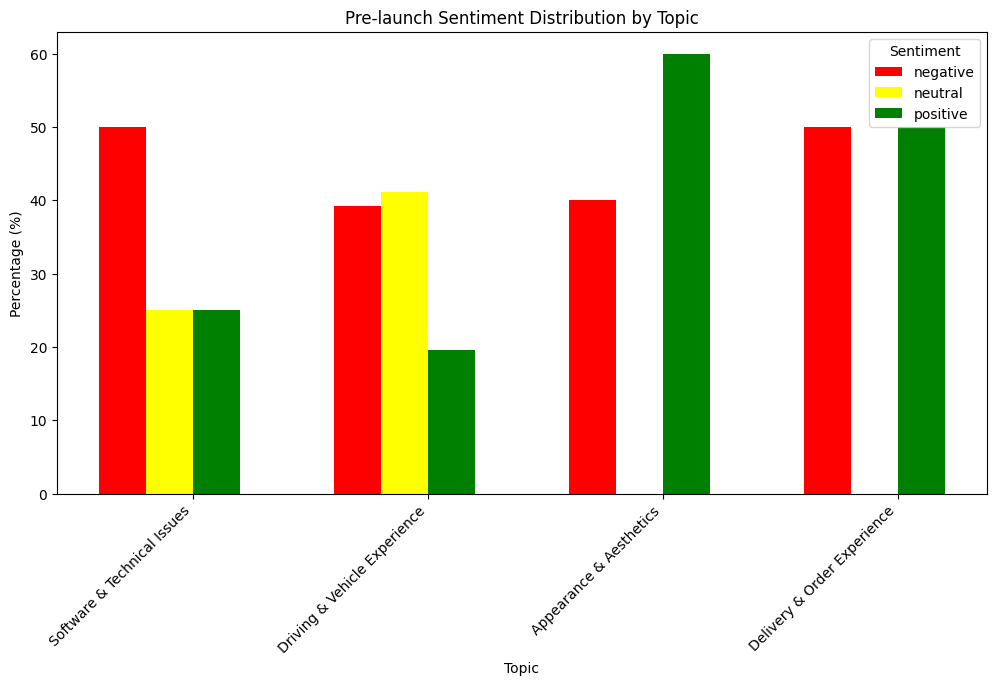

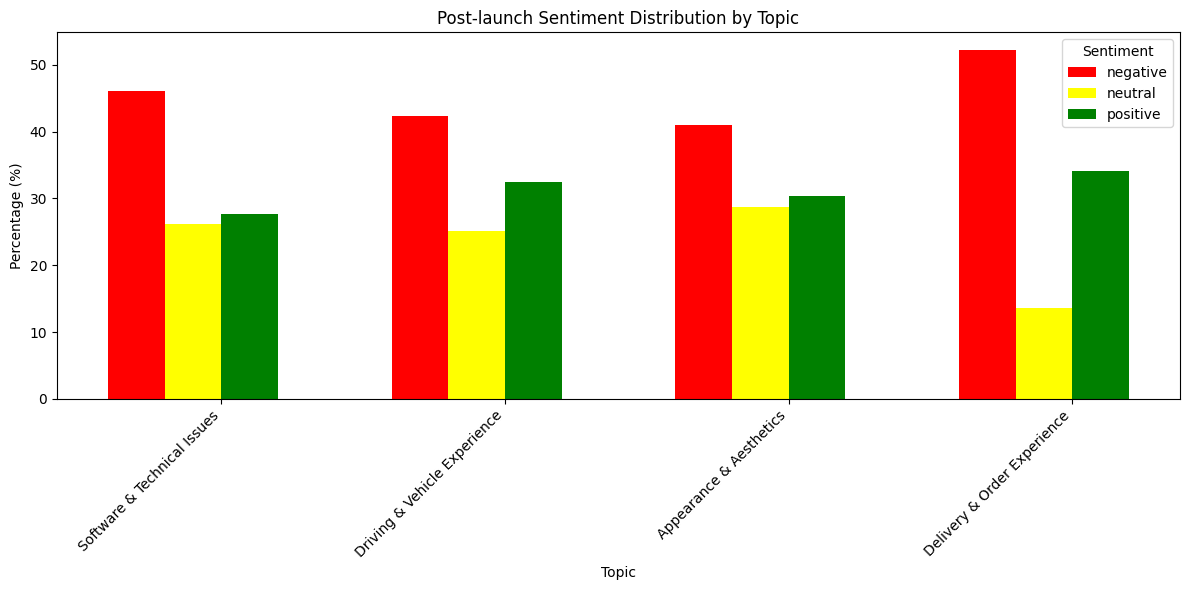

In [20]:
# Define topic keywords for the four predefined topics
topic_keywords = {
    0: ["issue", "work", "key", "dealer", "problem", "software", "suspension", "phone", "macan"],
    1: ["stelvio", "engine", "issue", "mode", "display", "like", "setting", "day", "seat", "driving"],
    2: ["look", "like", "door", "looking", "good", "better", "macan", "sound", "dealer", "trofeo"],
    3: ["dealer", "delivery", "order", "month", "post", "week", "info", "start", "update", "percent"]
}

# Categorize comments into topics based on keywords
def categorize_comment(cleaned_review):
    for topic, keywords in topic_keywords.items():
        for keyword in keywords:
            if keyword in cleaned_review:
                return topic
    return -1  # Return -1 for unclassified comments

# Apply the categorization function to each comment and create a new 'topic' column
grecale_data['topic'] = grecale_data['cleaned_review'].apply(categorize_comment)

# Remove unclassified comments (topic = -1) if needed
grecale_data = grecale_data[grecale_data['topic'] != -1]

# Define topic titles for the four topics
topic_titles = {
    0: "Software & Technical Issues",
    1: "Driving & Vehicle Experience",
    2: "Appearance & Aesthetics",
    3: "Delivery & Order Experience"
}

# Define sentiment labels and colors
sentiment_colors = {
    'negative': 'red',
    'neutral': 'yellow',
    'positive': 'green'
}

# Filter data for pre-launch and post-launch periods
prelaunch_data = grecale_data[grecale_data['Date'] < '2022-03-01']
postlaunch_data = grecale_data[grecale_data['Date'] >= '2022-03-01']

# Group the data by topic and sentiment, and calculate the count and percentage for pre-launch
prelaunch_topic_sentiment_count = prelaunch_data.groupby(['topic', 'sentiment_label'])['cleaned_review'].count().reset_index()
prelaunch_total_comments = prelaunch_topic_sentiment_count.groupby(['topic'])['cleaned_review'].sum()
prelaunch_topic_sentiment_count['percentage'] = prelaunch_topic_sentiment_count.apply(
    lambda row: row['cleaned_review'] / prelaunch_total_comments[row['topic']] * 100, axis=1
)

# Pivot the data for pre-launch visualization
prelaunch_pivot_data = prelaunch_topic_sentiment_count.pivot(index='topic', columns='sentiment_label', values='percentage')
prelaunch_pivot_data = prelaunch_pivot_data.fillna(0)

# Create a grouped bar chart for pre-launch with tilted topic labels and colored bars
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2
index = np.arange(len(prelaunch_pivot_data))

for i, sentiment in enumerate(sentiment_colors.keys()):
    ax.bar(
        index + i * bar_width,
        prelaunch_pivot_data[sentiment],
        bar_width,
        label=sentiment,
        color=sentiment_colors[sentiment]
    )

ax.set_title('Pre-launch Sentiment Distribution by Topic')
ax.set_xlabel('Topic')
ax.set_ylabel('Percentage (%)')
ax.set_xticks(index + (bar_width * 1.5))
ax.set_xticklabels([topic_titles[i] for i in prelaunch_pivot_data.index], rotation=45, ha="right")
ax.legend(title='Sentiment', loc='upper right')

# Create a grouped bar chart for post-launch with tilted topic labels and colored bars
postlaunch_topic_sentiment_count = postlaunch_data.groupby(['topic', 'sentiment_label'])['cleaned_review'].count().reset_index()
postlaunch_total_comments = postlaunch_topic_sentiment_count.groupby(['topic'])['cleaned_review'].sum()
postlaunch_topic_sentiment_count['percentage'] = postlaunch_topic_sentiment_count.apply(
    lambda row: row['cleaned_review'] / postlaunch_total_comments[row['topic']] * 100, axis=1
)
postlaunch_pivot_data = postlaunch_topic_sentiment_count.pivot(index='topic', columns='sentiment_label', values='percentage')
postlaunch_pivot_data = postlaunch_pivot_data.fillna(0)

# Create a grouped bar chart for post-launch with tilted topic labels and colored bars
fig2, ax2 = plt.subplots(figsize=(12, 6))
index2 = np.arange(len(postlaunch_pivot_data))

for i, sentiment in enumerate(sentiment_colors.keys()):
    ax2.bar(
        index2 + i * bar_width,
        postlaunch_pivot_data[sentiment],
        bar_width,
        label=sentiment,
        color=sentiment_colors[sentiment]
    )

ax2.set_title('Post-launch Sentiment Distribution by Topic')
ax2.set_xlabel('Topic')
ax2.set_ylabel('Percentage (%)')
ax2.set_xticks(index2 + (bar_width * 1.5))
ax2.set_xticklabels([topic_titles[i] for i in postlaunch_pivot_data.index], rotation=45, ha="right")
ax2.legend(title='Sentiment', loc='upper right')

plt.tight_layout()
plt.show()

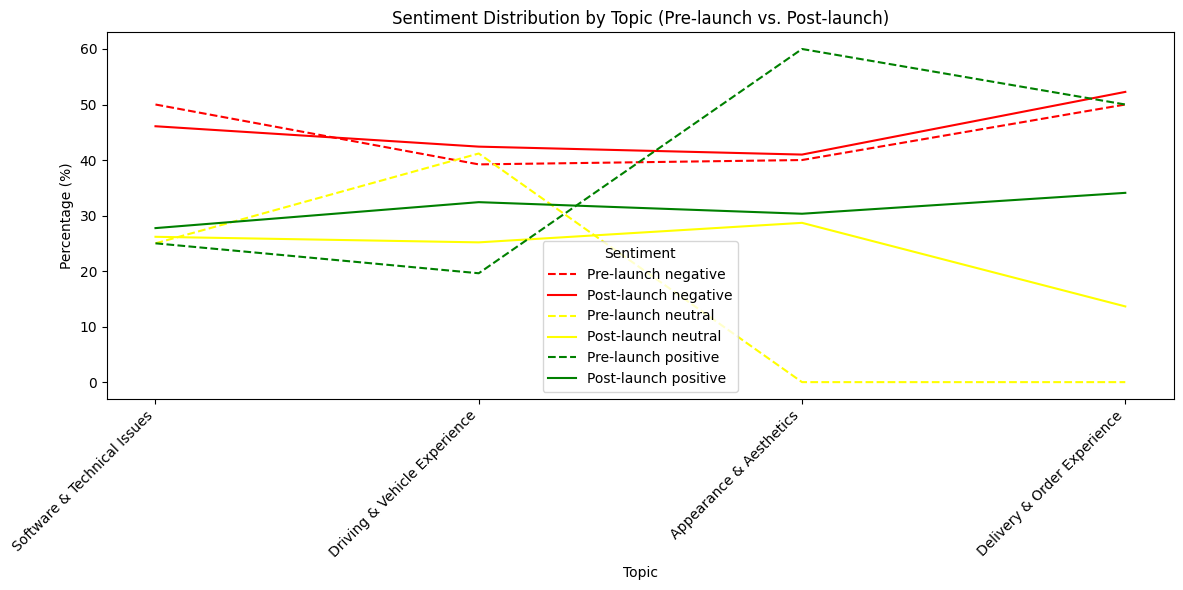

In [21]:
# Define topic keywords for the four predefined topics
topic_keywords = {
    0: ["issue", "work", "key", "dealer", "problem", "software", "suspension", "phone", "macan"],
    1: ["stelvio", "engine", "issue", "mode", "display", "like", "setting", "day", "seat", "driving"],
    2: ["look", "like", "door", "looking", "good", "better", "macan", "sound", "dealer", "trofeo"],
    3: ["dealer", "delivery", "order", "month", "post", "week", "info", "start", "update", "percent"]
}

# Categorize comments into topics based on keywords
def categorize_comment(cleaned_review):
    for topic, keywords in topic_keywords.items():
        for keyword in keywords:
            if keyword in cleaned_review:
                return topic
    return -1  # Return -1 for unclassified comments

# Apply the categorization function to each comment and create a new 'topic' column
grecale_data['topic'] = grecale_data['cleaned_review'].apply(categorize_comment)

# Remove unclassified comments (topic = -1) if needed
grecale_data = grecale_data[grecale_data['topic'] != -1]

# Define topic titles for the four topics
topic_titles = {
    0: "Software & Technical Issues",
    1: "Driving & Vehicle Experience",
    2: "Appearance & Aesthetics",
    3: "Delivery & Order Experience"
}

# Define sentiment labels and colors
sentiment_colors = {
    'negative': 'red',
    'neutral': 'yellow',
    'positive': 'green'
}

# Filter data for pre-launch and post-launch periods
prelaunch_data = grecale_data[grecale_data['Date'] < '2022-03-01']
postlaunch_data = grecale_data[grecale_data['Date'] >= '2022-03-01']

# Group the data by topic and sentiment, and calculate the count and percentage for pre-launch
prelaunch_topic_sentiment_count = prelaunch_data.groupby(['topic', 'sentiment_label'])['cleaned_review'].count().reset_index()
prelaunch_total_comments = prelaunch_topic_sentiment_count.groupby(['topic'])['cleaned_review'].sum()
prelaunch_topic_sentiment_count['percentage'] = prelaunch_topic_sentiment_count.apply(
    lambda row: row['cleaned_review'] / prelaunch_total_comments[row['topic']] * 100, axis=1
)

# Pivot the data for pre-launch visualization
prelaunch_pivot_data = prelaunch_topic_sentiment_count.pivot(index='topic', columns='sentiment_label', values='percentage')
prelaunch_pivot_data = prelaunch_pivot_data.fillna(0)

# Group the data by topic and sentiment, and calculate the count and percentage for post-launch
postlaunch_topic_sentiment_count = postlaunch_data.groupby(['topic', 'sentiment_label'])['cleaned_review'].count().reset_index()
postlaunch_total_comments = postlaunch_topic_sentiment_count.groupby(['topic'])['cleaned_review'].sum()
postlaunch_topic_sentiment_count['percentage'] = postlaunch_topic_sentiment_count.apply(
    lambda row: row['cleaned_review'] / postlaunch_total_comments[row['topic']] * 100, axis=1
)

# Pivot the data for post-launch visualization
postlaunch_pivot_data = postlaunch_topic_sentiment_count.pivot(index='topic', columns='sentiment_label', values='percentage')
postlaunch_pivot_data = postlaunch_pivot_data.fillna(0)

# Create a line chart for pre-launch and post-launch with topic labels
fig, ax = plt.subplots(figsize=(12, 6))
index = np.arange(len(prelaunch_pivot_data))

for sentiment in sentiment_colors.keys():
    ax.plot(index, prelaunch_pivot_data[sentiment], label=f'Pre-launch {sentiment}', linestyle='--', color=sentiment_colors[sentiment])
    ax.plot(index, postlaunch_pivot_data[sentiment], label=f'Post-launch {sentiment}', color=sentiment_colors[sentiment])

ax.set_title('Sentiment Distribution by Topic (Pre-launch vs. Post-launch)')
ax.set_xlabel('Topic')
ax.set_ylabel('Percentage (%)')
ax.set_xticks(index)
ax.set_xticklabels([topic_titles[i] for i in prelaunch_pivot_data.index], rotation=45, ha="right")
ax.legend(title='Sentiment')

plt.tight_layout()
plt.show()